---
Preparing GFF file into df_indexed. 

In [190]:
file_gff = '/ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3'
df_gff   = pd.read_csv(file_gff,sep='\t',skiprows=2,header=None)

# For CRE
#df_gff['genename'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))
#df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:4]))


dicT2G      = {} # transcript to genename
df_gff_mRNA = df_gff[(df_gff[2] == 'mRNA')]
def get_genename(x):
    if x[2] == 'gene':
        return None
    key   = [y.split('=')[0] for y in x[8].split(';')]
    value = [y.split('=')[1] for y in x[8].split(';')]
    dic   = dict(zip(key,value))
    return dic['Parent']
def get_transcript(x):
    
    
    key   = [y.split('=')[0] for y in x[8].split(';')]
    value = [y.split('=')[1] for y in x[8].split(';')]
    dic   = dict(zip(key,value))
    if x[2] == 'gene':
        return None
    elif x[2] == 'mRNA':
        return dic['ID']
    else: 
        return dic['Parent']
df_gff_mRNA['genename']   = df_gff_mRNA.apply(get_genename,axis=1)
df_gff_mRNA['transcript'] = df_gff_mRNA.apply(get_transcript,axis=1)
df_gff_mRNA_ix = df_gff_mRNA.set_index('transcript')
# For ESA
df_gff['transcriptname']  = df_gff.apply(get_transcript,axis=1)



def get_genename2(x):
    if x != None:
        return df_gff_mRNA_ix.loc[x]['genename']
    else:
        return None
df_gff['genename'] = df_gff['transcriptname'].apply(get_genename2)



# grep longest transcript names
df_gff_mRNA_ix['longest'] = df_gff_mRNA_ix[8].apply(lambda x : x.split(';')[3].replace('longest=',''))
#df_gff_mRNA_index =  df_gff_mRNA.set_index('transcript')

def get_longest(x):
    if x == None:
        return None
    try:
        return df_gff_mRNA_ix.loc[x]['longest']
    except KeyError:
        return None
df_gff['longest'] = df_gff['transcriptname'].apply(get_longest)

df_gff_index = df_gff.set_index(['genename','longest'])

df_gff_index.head()

IOError: File /ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3 does not exist

In [60]:
df_gff_index.to_pickle(file_gff+'.pandas.df.pk')

**START**

In [193]:
import pandas as pd
import subprocess
import re
from __future__ import print_function
import numpy as np

In [194]:
file_bam = '/ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam'
#df_gene_gff = pd.read_pickle('../../genemodel_correction/tophat/df.cre.gff.gene.index.pickle')

---

In [195]:
df_gff_index = pd.read_pickle('/ref/analysis/pipelines/pandas_df/Esalsugineum_173_v1.0.gene.gff3.pandas.df.pk')

In [196]:
df_gff_ix = df_gff_index.reset_index().set_index(['genename','longest',2])

In [197]:

df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


array([['scaffold_2', 2676548, 2677563]], dtype=object)

In [198]:
def draw_alignment(genename):
    print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-20 temp.sam > temp.sam.cut',shell=True)

    df_sam = pd.read_csv('temp.sam.cut',sep='\t',header=None)

    df_sam['SRRID']  = df_sam[0].apply(lambda x:x.split('.')[0])
    df_sam['READID'] = df_sam[0].apply(lambda x:x.split('.')[1])
    try:
        df_sam['PAIRID'] = df_sam[0].apply(lambda x:x.split('.')[2])
        bPaired = 1
    except IndexError:
        bPaired = 0

    mask = (df_sam[8] > 0)
    df_sam_forward = df_sam[mask]
    df_sam_forward = df_sam_forward.sort(3)
    READID_LIST    = df_sam_forward['READID']
    if bPaired == 1:
        df_sam_index = df_sam.set_index(['SRRID','READID','PAIRID'])
    else: 
        df_sam_index = df_sam.set_index(['SRRID','READID'])
    df_sam_index = df_sam_index.sort([3])

    def cigar_parse(cigar):
        match = re.findall(r'(\d+)(\w)', cigar)
        return match

    # SVG
    rect = '<rect x="%d" y="%d" width="%d" height="%d" style="fill:%s;stroke:%s;stroke-width:1;fill-opacity:0.8;stroke-opacity:0.3" />'
    line = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />'
    text = '<text x="%d"  y="%d" style="font-family:Arial;font-size:%d;stroke:black;fill:black;">%s</text>'

    Outfile = open('%s.%s.svg'%(genename,file_bam.split('/')[-1]),'w')

    each_height   = 5
    each_space    = 2
    box_height    = 3
    bridge_height = 2
    genestart     = 3

    total_canvas_rows = 100 + genestart# 2 for gene model

    canvas_width = 1000
    canvas_height = total_canvas_rows*(each_height+each_space)

    real_width = right-left+1+100+100

    print('''<svg height="%d" width="%d">'''%(canvas_height,canvas_width),file=Outfile)
    gene_space = np.zeros([total_canvas_rows,real_width]) # 100 for paired end stretching out of border

    ############################################################################ drawing space set
    def get_ratio(x):
        return int(float(x)/float(real_width) * canvas_width)


    df = df_gff_index.loc[(genename,'1')]
    df = df.reset_index()
    df = df.sort(3)

    fill_CDS   = 'yellow'
    strock_CDS = 'black'

    fill_UTR   = 'blue'
    strock_UTR = 'black'



    for i in df.index:
        if df.loc[i][2] == 'mRNA':
            x1 = get_ratio(df.loc[i][3] - left + 100)
            y1 = int(each_height/2) + genestart + 1
            x2 = get_ratio(df.loc[i][4] - left + 100)
            y2 = int(each_height/2) + genestart + 1
            print(line%(x1,y1,x2,y2,'black'),file=Outfile)
        elif 'UTR' in df.loc[i][2]:
            x1 = get_ratio(df.loc[i][3] - left + 100)
            y1 = genestart + 1 
            w  = get_ratio(df.loc[i][4] - df.loc[i][3])
            h  = each_height
            print(rect%(x1,y1,w,h,fill_UTR,strock_UTR),file=Outfile)
        elif 'CDS' in df.loc[i][2]:
            x1 = get_ratio(df.loc[i][3] - left + 100)
            y1 = genestart + 1
            w  = get_ratio(df.loc[i][4] - df.loc[i][3])
            h  = each_height
            print(rect%(x1,y1,w,h,fill_CDS,strock_CDS),file=Outfile)

    print(text%(15,genestart+each_height*4,10,genename),file=Outfile)

    ########################################################################## gene model drawing


    SRRID_list = set(df_sam_index.index.get_level_values('SRRID'))
    readnumber = 0
    bPass = 1
    for SRRID in SRRID_list:
        READID_list = df_sam_index.loc[SRRID].index.get_level_values('READID')
        for READID in READID_list:
            #print(READID)
            if bPaired == 1:  
                df = df_sam_index.loc[(SRRID,READID)]
                if len(df) == 2:
                    pass
                else: continue
            else:
                if len(df_sam_index.loc[(SRRID,READID)]) < 10: # in the case of multiple match. Just select first one ...
                    df = df_sam_index.loc[(SRRID,READID)].values[0]
                else:
                    df = df_sam_index.loc[(SRRID,READID)].values
            ##################################### cigar check start
            gap_length = 0
            match_length = 0
            if bPaired == 1:
                for cigar in df[5]:
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM]
                    for i, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'N' or cigarstring == 'I':
                            gap_length += int(cigarvalues[i])
                        if cigarstring == 'M':
                            match_length += int(cigarvalues[i])
            else:
                try:
                    cigarM       = cigar_parse(df[5])
                except IndexError:
                    print(df) # Sanity check 
                cigarstrings = [x[1] for x in cigarM]
                cigarvalues  = [x[0] for x in cigarM]
                for i, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'N' or cigarstring == 'I':
                        gap_length += int(cigarvalues[i])
                    if cigarstring == 'M':
                        match_length += int(cigarvalues[i])

            #print(gap_length,match_length)
            if bPaired == 1:
                fragstart      = min(df[3])-left+100
            else:
                #print (df)
                fragstart    = df[3]-left+100
            if fragstart < 0:
                continue
            if bPaired == 1:
                fragmentsize   = max(df[8])
                fragmentsize_r = min(df[8])
                insertsize     = fragmentsize - gap_length - 200
            if bPaired == 1:
                if insertsize < 10:
                    continue
                if fragmentsize_r > 0 :
                    continue
            else: pass
            ##################################################################### Error remove
            srow = None
            for nrow, row in enumerate(gene_space):
                if nrow <= 3:
                    continue
                if bPaired == 1:
                    if max(row[fragstart:fragstart+fragmentsize]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+fragmentsize] += 1
                        break
                else:
                    #print(fragstart)
                    if max(row[fragstart:fragstart+match_length+gap_length]) > 0 :
                        continue
                    else:
                        srow = nrow
                        gene_space[srow,fragstart:fragstart+match_length+gap_length] += 1
                        break

            if srow == None:
                continue
            #print(srow)
            ##################################################################### Row selection 
            readnumber = srow
            #print(readnumber)
            if bPaired == 1:
                for i in df.index:
                    fragsize          = df.loc[i][8]
                    startpoint        = df.loc[i][3]
                    secondstartpoint  = df.loc[i][7]
                    cigar        = df.loc[i][5]
                    cigarM       = cigar_parse(cigar)
                    #print(cigarM)
                    cigarstrings = [x[1] for x in cigarM]
                    cigarvalues  = [x[0] for x in cigarM] 
                    ##################################################################
                    coverleng = 0
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M' or cigarstring == 'N' or cigarstring == 'I':
                            coverleng += int(cigarvalues[j])
                    if fragsize > 0:
                        x1 = get_ratio(startpoint - left + 100 + coverleng)
                        y1 = readnumber * (each_height + each_space) + int(each_height/2)

                        y2 = readnumber * (each_height + each_space) + int(each_height/2) + int(each_height/2)
                        x3 = get_ratio(secondstartpoint - left + 100)
                        x2 = (x3 + x1)/2
                        print(line%(x1,y1,x2,y2,'black'),file=Outfile)
                        print(line%(x2,y2,x3,y1,'black'),file=Outfile)

                    ################################################################# paired end line
                    #print(i)
                    w = 0
                    #print (cigarstrings)
                    #print (cigarvalues)
                    for j, cigarstring in enumerate(cigarstrings):
                        if cigarstring == 'M':
                            x = get_ratio(w + startpoint - left + 100)
                            #print(x)
                            if x < 0:
                                continue
                            y = readnumber * (each_height + each_space)

                            h = int(each_height)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            #print(x,y,w,h)
                            print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                        elif cigarstring == 'N' or cigarstring == 'I':
                            x1 = get_ratio(w + startpoint - left + 100)
                            if x1 < 0:
                                continue
                            y1 = readnumber * (each_height + each_space) + int(each_height/2)
                            ew = int(cigarvalues[j]) # each width
                            w += ew
                            x2 = get_ratio(w + startpoint - left + 100)

                            print(line%(x1,y1,x2,y1,'red'),file=Outfile)
            else:
                fragsize          = df[8]
                startpoint        = df[3]
                secondstartpoint  = df[7]
                #print(df)
                cigar             = df[5]
                cigarM            = cigar_parse(cigar)
                #print(cigarM)
                cigarstrings      = [x[1] for x in cigarM]
                cigarvalues       = [x[0] for x in cigarM]
                w = 0 
                for j, cigarstring in enumerate(cigarstrings):
                    if cigarstring == 'M':
                        x = get_ratio(w + startpoint - left + 100)
                        #print(x)
                        if x < 0:
                            continue
                        y = readnumber * (each_height + each_space)

                        h = int(each_height)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        #print(x,y,w,h)
                        print(rect%(x,y,get_ratio(ew),h,'pink','black'),file=Outfile)

                    elif cigarstring == 'N' or cigarstring == 'I':
                        x1 = get_ratio(w + startpoint - left + 100)
                        if x1 < 0:
                            continue
                        y1 = readnumber * (each_height + each_space) + int(each_height/2)
                        ew = int(cigarvalues[j]) # each width
                        w += ew
                        x2 = get_ratio(w + startpoint - left + 100)

                        print(line%(x1,y1,x2,y1,'red'),file=Outfile)


    print('''</svg>
    ''',file=Outfile)

    Outfile.close()               

문제 발견! 만약에 insert size로 필터를 하고 싶을때 fragment size로 필터하려고 하면 문제가 생김. 왜냐면 spliced part 까지 포함해서 fragment size를 기록하므로 아무리 큰값으로 필터를 해봐야 여전히 insert size가 readlength 보다 작은 애들이 포함되게 된다. 저놈들이 그림에서 보이는 overlapped reads 웃긴건 저런놈들이 잇는 자리는 뭔가 일관되지 않다는것. 개떡같네 정말 ㅅㅂ. 일단 코드에 insert size를 정확하게 계산하는 부분을 넣도록 하자. 

In [199]:
genename = 'Thhalv10014963m.g.v1.0'
chromosome, left, right = df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values[0]
print(chromosome, left, right) 
draw_alignment(genename)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


scaffold_2 2676548 2677563
samtools view /ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam scaffold_2:2676548-2677563 > temp.sam


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:60: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:109: PerformanceWarning: indexing past lexsort depth may impact performance.


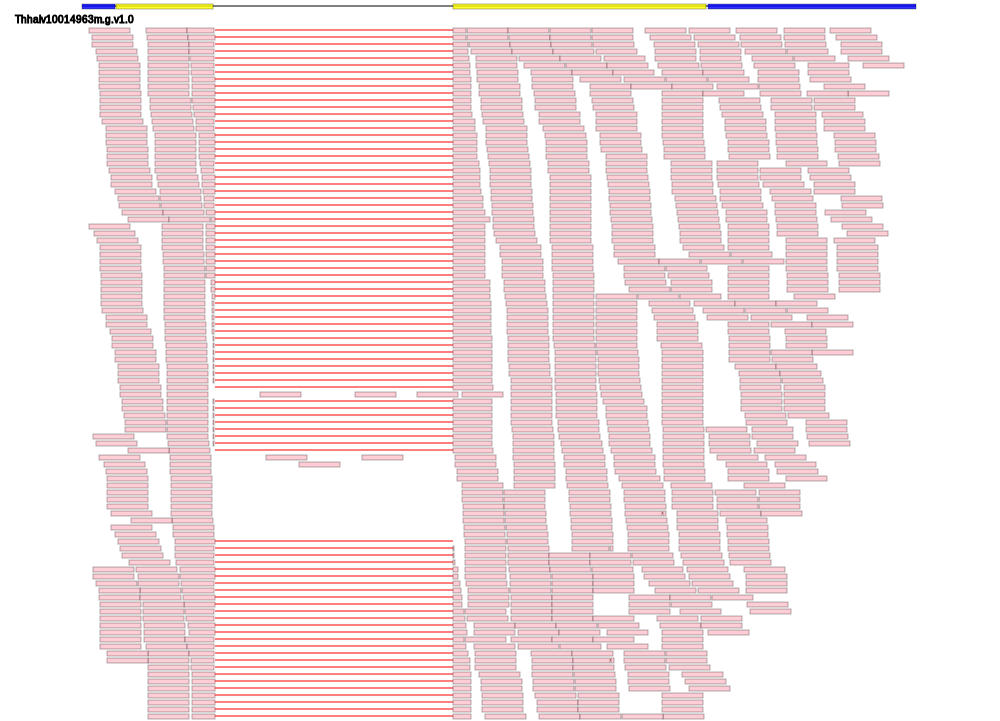

In [179]:
from IPython.display import SVG, display
display(SVG('./%s.%s.svg'%(genename,file_bam.split('/')[-1])))

In [132]:
df_sam_index.loc[(SRRID,READID)].values[0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


array(['SRR1617535.24084007', 16, 'scaffold_1', 4441356, 50, '50M', '*', 0,
       0, 'TTACTTGAAACTCATTATTTGTGATACTTTGGATTGGAATCTTATGGGTG',
       'JIGJJJJIIFJIIIJJJJJJJJJIHEJJJJJJJJJJJHHHHHFFFFFCCC', 'AS:i:-10',
       'XN:i:0', 'XM:i:2', 'XO:i:0', 'XG:i:0', 'NM:i:2', 'MD:Z:48A0A0',
       'YT:Z:UU'], dtype=object)

In [138]:

df_sam_index.loc[('SRR1617532','12153605')]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  from ipykernel import kernelapp as app


KeyError: '12153605'

In [203]:
%save "RNAseq.bam.visualization.draw.py" 193-200

File `RNAseq.bam.visualization.draw.py` exists. Overwrite (y/[N])?  y
The following commands were written to file `RNAseq.bam.visualization.draw.py`:
import pandas as pd
import subprocess
import re
from __future__ import print_function
import numpy as np
file_bam = '/ref/analysis/DroughtNet/DroughtNet.NCBI/ESA/merge/ESAmerged.bam'
#df_gene_gff = pd.read_pickle('../../genemodel_correction/tophat/df.cre.gff.gene.index.pickle')
df_gff_index = pd.read_pickle('/ref/analysis/pipelines/pandas_df/Esalsugineum_173_v1.0.gene.gff3.pandas.df.pk')
df_gff_ix = df_gff_index.reset_index().set_index(['genename','longest',2])

df_gff_ix.loc[(genename,'1','mRNA')][[0,3,4]].values
def draw_alignment(genename):
    print ('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right))
    subprocess.call('samtools view %s %s:%d-%d > temp.sam'%(file_bam,chromosome,left,right),shell=True)
    subprocess.call('cut -f 1-20 temp.sam > temp.sam.cut',shell=True)

    df_sam = pd.read_csv('temp.sam.cut',s

In [191]:
_ih[190]

u"file_gff = '/ref/Cre/DroughtNet/PhytozomeV10_download/References/Alyrata/annotation/Alyrata_107_v1.0.gene_exons.gff3'\ndf_gff   = pd.read_csv(file_gff,sep='\\t',skiprows=2,header=None)\n\n# For CRE\n#df_gff['genename'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:2]))\n#df_gff['transcriptname'] = df_gff[8].apply(lambda x : '.'.join(x.split(';')[0].replace('ID=','').split('.')[0:4]))\n\n\ndicT2G      = {} # transcript to genename\ndf_gff_mRNA = df_gff[(df_gff[2] == 'mRNA')]\ndef get_genename(x):\n    if x[2] == 'gene':\n        return None\n    key   = [y.split('=')[0] for y in x[8].split(';')]\n    value = [y.split('=')[1] for y in x[8].split(';')]\n    dic   = dict(zip(key,value))\n    return dic['Parent']\ndef get_transcript(x):\n    \n    \n    key   = [y.split('=')[0] for y in x[8].split(';')]\n    value = [y.split('=')[1] for y in x[8].split(';')]\n    dic   = dict(zip(key,value))\n    if x[2] == 'gene':\n        return None\n    elif x[2]